In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.sparse
import pandas as pd
import altair
import seaborn
RANDOM_SEED = 511
rng = np.random.default_rng(RANDOM_SEED)
seaborn.set_theme(style="darkgrid")
altair.renderers.enable('mimetype')
db_url = os.getenv('DB_URL')

In [142]:
zip_code_sql = """
select
    (row_number() over (order by zip_code)) - 1 as i,
    zip_code,
    coalesce(otp_capacity, 0)::int as otp_capacity,
    coalesce(patient_admissions_3_2019, 0)::int as otp_patients
from zip_code_otp_analysis
order by zip_code
"""

zip_df = pd.read_sql(zip_code_sql, con=db_url)
zip_df = zip_df.set_index('i')
zip_df.head(3).T

i,0,1,2
zip_code,10001,10002,10003
otp_capacity,1000,1473,0
otp_patients,199,110,115


In [147]:
zip_df['otp_capacity'] = zip_df['otp_capacity'] * 12000 / zip_df['otp_capacity'].sum()
zip_df[['otp_capacity', 'otp_patients']].sum()

otp_capacity    12000.0
otp_patients    11541.0
dtype: float64

In [121]:

travel_time_sql = """
with zips as (
    select
        (row_number() over (order by zip_code)) - 1 as i,
        zip_code
    from zip_code_otp_analysis
)
select
    z1.i as from_i,
    z2.i as to_i,
    travel_time
from zip_code_distances
    join zips as z1 on from_zip_code = z1.zip_code
    join zips as z2 on to_zip_code = z2.zip_code
"""

time_df = pd.read_sql(travel_time_sql, con=db_url)\
    .astype(np.int32)
time_df.head(3).T


,0,1,2
from_i,171,171,171
to_i,171,99,98
travel_time,0,1712,1458


## Optimize Assignment of Patients to Current Capacity

Note: capacity greatly exceeds known patient count, which makes this relatively easy!

First, linearly in time...

In [9]:
from ortools.linear_solver import pywraplp
from ortools.init import pywrapinit

In [163]:
solver = pywraplp.Solver.CreateSolver('SCIP')

p = zip_df['otp_patients'].values
c = zip_df['otp_capacity'].values
t = scipy.sparse.coo_array((
    time_df['travel_time'].values, 
    (time_df['from_i'].values, time_df['to_i'].values)
)).todense()

# Vector of variables: flow from source i to sink = pc_ij
pc = np.array([
    [
        solver.IntVar(0, int(p[i]), f'p{i}-c{j}')
        if p[i] > 0 and c[j] > 0
        else None
        for j in range(len(p))
    ]
    for i in range(len(p))
])
print('Number of variables =', solver.NumVariables())

# Constraint: sum_j pc_ij = p_i
for i in range(len(p)):
    if not any(pc[i, :]):
        continue
    constraint = sum(var for var in pc[i, :] if var is not None) == p[i]
    solver.Add(constraint)

# Constraint: sum_i pc_ij <= c_j
for j in range(len(p)):
    if not any(pc[:, j]):
        continue
    constraint = sum(var for var in pc[:, j] if var is not None) <= c[j]
    solver.Add(constraint)

print('Number of constraints =', solver.NumConstraints())

# Minimize: sum_j pc_ij f(t_ij) 
# (Linear in time objective)
costs = np.where(t / 60 > 15, (t / 60 - 15), 0)
objective = sum(
    pc[i, j] * (costs[i, j])
    for i in range(len(p))
    for j in range(len(p))
    if pc[i, j] is not None
)
solver.Minimize(objective)

Number of variables = 6536
Number of constraints = 210


In [164]:
status = solver.Solve()
print(status == pywraplp.Solver.OPTIMAL)

True


In [1]:

solution = np.array([
    [
        v.solution_value() if v is not None else 0
        for v in row
    ]
    for row in pc
])
print((~(solution.sum(axis=1) == p)).sum())
print((~(solution.sum(axis=0) <= c)).sum())
# print(solution[0, :])
# print(solution[:, 0])

NameError: name 'np' is not defined

Well, that was all pointless. If I want to measure how bad the current travel times are, I just need to
look directly at the current travel times.

* Optimize assignment of capacity? Just put it wherever the patients are.
* No reason to think "capacity" actually lines up with total admissions...
    * capacity and avg daily enrollment are quite correlated, admissions less so.
* Why was total of avg daily enrollment = total of admissions? Are those the same somehow?
    * wow, this SQL plugin is garbage, it just equaters columns with the same name.
* Where is all the extra (unused) capacity?

In [12]:
sql = """
select
    program_number,
    program_name,
    current_certified_capacity as capacity,
    coalesce(total_admissions_3_2019, 0) as admissions,
    avg_daily_enrollment_2019 as avg_daily_enrollment
from programs_analysis
    join programs using (program_number)
where program_category = 'Opioid Treatment Program'
"""
program_df = pd.read_sql(sql, con=db_url)
program_df.head(3).T

,0,1,2
program_number,6,7,8
program_name,Starting Point Clinic OTP,Fort Greene Clinic OTP,Kaleidoscope Clinic OTP
capacity,300.0,500.0,300.0
admissions,224,232,172
avg_daily_enrollment,335.0,504.0,330.0


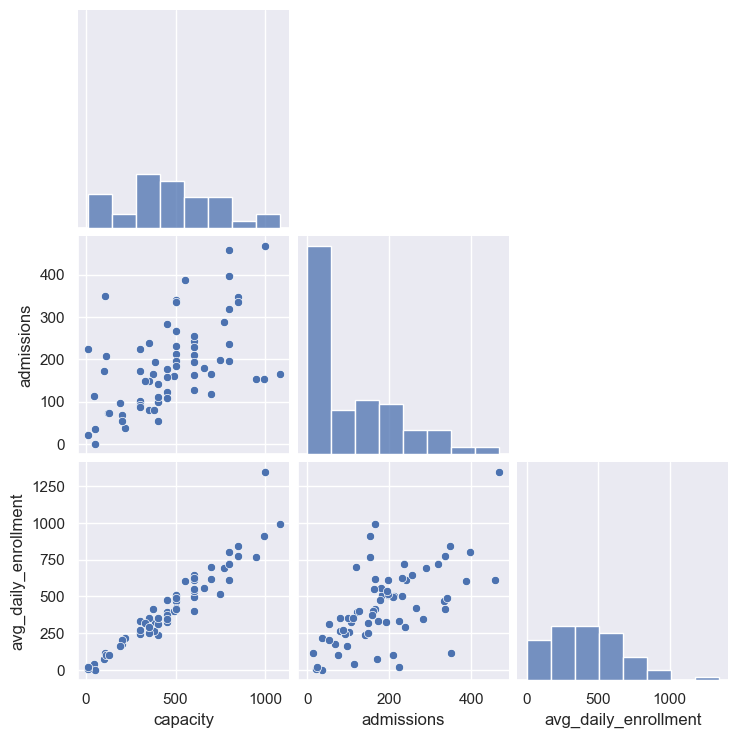

In [13]:
p = seaborn.pairplot(
    program_df[['capacity', 'admissions', 'avg_daily_enrollment']],
    corner=True
);


In [22]:
sql = """
select
    address_zip_code as zip_code,
    travel_time / 60 as travel_time_minutes,
    sum(coalesce(total_admissions, 3)) as admissions,
    sum(coalesce(total_admissions, 3))::float / sum(sum(coalesce(total_admissions, 3))) over () as f_admissions
from program_admissions_2019
    join programs using (program_number)
    join zip_code_distances on programs.address_zip_code = to_zip_code
        and patient_zip_code = from_zip_code
where program_category = 'Opioid Treatment Program'
-- and borough_district_code in (110, 111)
group by 1, 2
"""
travel_df = pd.read_sql(sql, con=db_url)
print(travel_df.shape)
travel_df.head(3).T

(1836, 4)


,0,1,2
zip_code,10010,11231,11238
travel_time_minutes,16.45,36.083333,49.0
admissions,3,6,6
f_admissions,0.00026,0.00052,0.00052


''

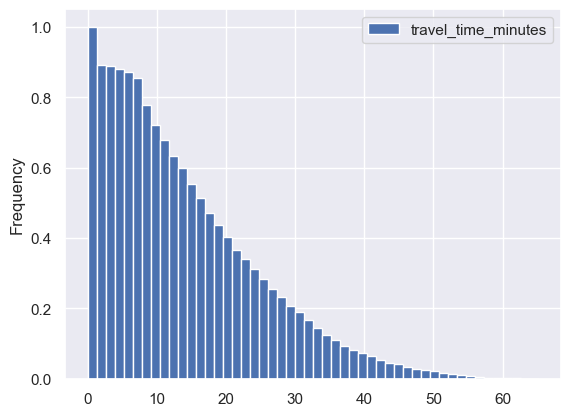

In [24]:
travel_df.plot(
    kind='hist', 
    y='travel_time_minutes',
    bins=50,
    cumulative=-1,
    weights=travel_df['f_admissions'],
)
;

In [13]:
travel_df.sort_values('travel_time_minutes').tail(5)

,zip_code,travel_time_minutes,admissions
80,10027,56.783333,3
81,10027,59.666667,3
256,10035,60.133333,3
134,10029,61.583333,3
135,10029,65.216667,3
